# Set up

In [27]:
import pandas as pd
import patsy
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math
import random

# Getting data

In [3]:
file_name = '../csvs/element_gameweek_features_v06.csv'

In [4]:
element_gameweek_df = pd.read_csv(file_name)

In [5]:
current_event = 38

In [6]:
last_train_event = 30

In [7]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [8]:
element_gameweek_df.fillna(
    element_gameweek_df[element_gameweek_df['event'] <= last_train_event].mean(),
    inplace=True
)

In [9]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

In [10]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [11]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

In [12]:
formula = \
'total_points ~ C(team) + C(opposition_team) + C(element_type) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
     'expected_total_points_against_opposition_team',
     'rolling_avg_total_points_element_home',
     'rolling_max_total_points_element',
     'rolling_avg_bps_element',
     'expected_total_points_element_home_away',
     'rolling_avg_total_points_element_away',
     'rolling_avg_total_points_own_team',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_minutes_element',
     'rolling_avg_total_points_opposition_team',
     'rolling_avg_dribbles_element',
     'rolling_avg_total_points_against_opposition_team_element_type',
     'rolling_avg_total_points_against_opposition_team_element_type_away',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_goals_conceded_element',
     'rolling_avg_completed_passes_element',
     'rolling_avg_total_points_element_type',
     'rolling_avg_recoveries_element',
 ]])

In [13]:
print(formula)

total_points ~ C(team) + C(opposition_team) + C(element_type) + was_home + is_sunday + is_weekday + is_early + is_late + value + rolling_avg_total_points_element + has_high_points_ever_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_clean_sheets_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolling_avg_attempted_passes_element + rolling_avg_errors_leading_to_goal_element + rolling_avg_errors_leading_to_goal_attempt_element + rolling_avg_own_goals_element + rolling_avg_penalties_concededd_element + rolling_avg_penalties_missed_element +

In [14]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [15]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Decision trees

Decision trees recursively partition the feature space into M regions using a series of binary splits - this is known as the CART methodology (Classification and Regression Trees).  

In each resulting region of the feature space we predict the target variable using the corresponding sample mean in that region.

$$ f(x) = \sum_{m=0}^M c_m \, I(x \in R_m) $$  

$$ \hat c_m = \bar y_m = {\sum_{i=0}^N y_i \, I(x_i \in R_m) \over \sum_{i=0}^N I(x_i \in R_m)} $$

For a given loss function, the feature set is split on a particular feature at a particular split point, so to minimise the loss. For regression trees, we use the squared error loss.

$$ R_1 = \{x \, | \, x_j <= s\}, \; R_2 = \{x \, | \, x_j > s\} $$

$$ \min_{j, s} \sum_{i=1}^N (y_i - \bar y_1)^2 I(x \in R_1) + (y_i - \bar y_2)^2 I(x \in R_2)  $$

Regions are recursively split until some stopping criteria is satisfied, e.g. the size of the tree. As such, a tree of binary decision junctions (nodes) is grown where each terminal node (leaf) corresponds to a certain region of the feature set.

## Growing a tree

We're going to grow a tree to predict the number of points scored by fantasy players based on a bunch of features, shown below

In [16]:
X.design_info.column_names

['Intercept',
 'C(team)[T.2]',
 'C(team)[T.3]',
 'C(team)[T.4]',
 'C(team)[T.5]',
 'C(team)[T.6]',
 'C(team)[T.7]',
 'C(team)[T.8]',
 'C(team)[T.9]',
 'C(team)[T.10]',
 'C(team)[T.11]',
 'C(team)[T.12]',
 'C(team)[T.13]',
 'C(team)[T.14]',
 'C(team)[T.15]',
 'C(team)[T.16]',
 'C(team)[T.17]',
 'C(team)[T.18]',
 'C(team)[T.19]',
 'C(team)[T.20]',
 'C(opposition_team)[T.2]',
 'C(opposition_team)[T.3]',
 'C(opposition_team)[T.4]',
 'C(opposition_team)[T.5]',
 'C(opposition_team)[T.6]',
 'C(opposition_team)[T.7]',
 'C(opposition_team)[T.8]',
 'C(opposition_team)[T.9]',
 'C(opposition_team)[T.10]',
 'C(opposition_team)[T.11]',
 'C(opposition_team)[T.12]',
 'C(opposition_team)[T.13]',
 'C(opposition_team)[T.14]',
 'C(opposition_team)[T.15]',
 'C(opposition_team)[T.16]',
 'C(opposition_team)[T.17]',
 'C(opposition_team)[T.18]',
 'C(opposition_team)[T.19]',
 'C(opposition_team)[T.20]',
 'C(element_type)[T.2]',
 'C(element_type)[T.3]',
 'C(element_type)[T.4]',
 'was_home',
 'is_sunday',
 'is_we

For simplicity, let's restrict our feature set to just a few features

In [23]:
example_cols = [
    'rolling_avg_saves_element',
    'is_sunday',
    'rolling_avg_red_cards_element',
]

example_features_index = \
[True if i in example_cols else False for i in X.design_info.column_names]

X_example = X[:,example_features_index]


We're also going to restrict our tree to a depth of 3

In [24]:
model_example = DecisionTreeRegressor(max_depth=3)

model_example.fit(X_example, y.ravel())

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

We can visualise the resulting decision tree

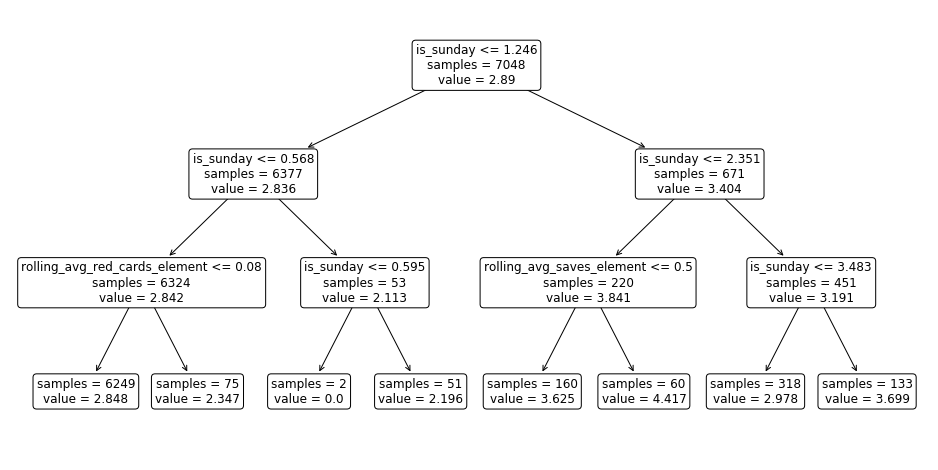

In [25]:
plt.figure(figsize=(16, 8))
plot_tree(
    model_example,
    impurity=False,
    fontsize=12,
    rounded=True,
    feature_names=example_cols
)
plt.show()

## Trees are unstable

Decision trees have some drawbacks, in particular they are known to typically be quite unstable, with small variations in training data leading to different tree structures.  

Here's another decision tree, this time trained on a dataset of the same length created by sampling from the previous dataset with replacement (bootstrapping); we see that the structure is quite different.


In [28]:
data_boot = random.choices(list(zip(X_example, y.ravel())), k=len(X_example)) 
X_boot = [i[0] for i in data_boot]
y_boot = [i[1] for i in data_boot]

In [29]:
model_boot = DecisionTreeRegressor(max_depth=3)

model_boot.fit(X_boot, y_boot)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

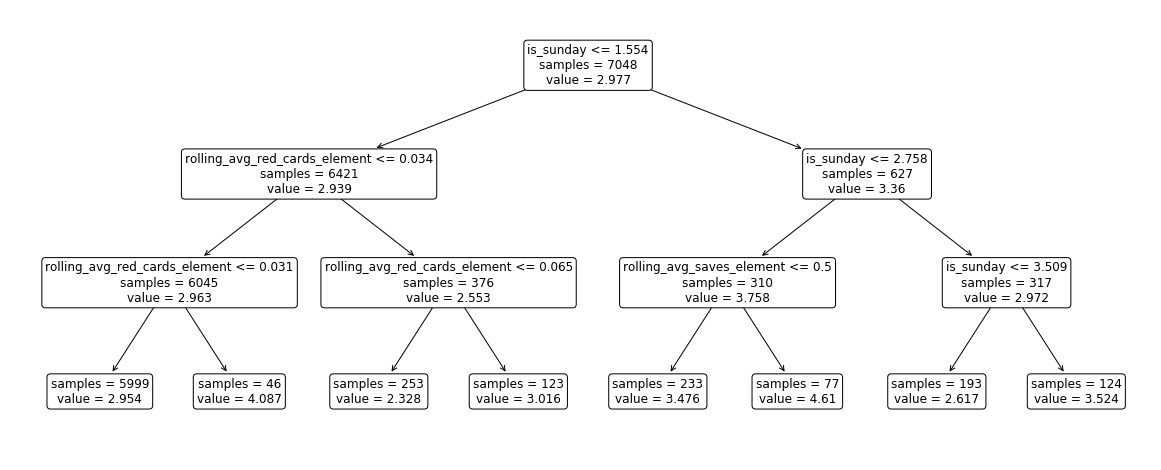

In [31]:
plt.figure(figsize=(20, 8))
plot_tree(
    model_boot,
    impurity=False,
    fontsize=12,
    rounded=True,
    feature_names=example_cols
)
plt.show()

## Tree size and overfitting

Typically in the CART methodology, large trees are grown and then pruned. Scikit-learn doesn't support pruning, so we prevent overfitting by limiting the tree size.  

There are several ways to control tree size, e.g. maximum tree depth, maximum number of leaves. We opt for setting a minimum number of samples at each leaf, which we determine using cross validation.

In [66]:
?DecisionTreeRegressor

In [98]:
tree_parameters = {
    'min_samples_leaf': np.linspace(0.02, 0.5, 100)
}

In [99]:
tree_model = GridSearchCV(
    DecisionTreeRegressor(),
    tree_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1)
tree_model.fit(X, y.ravel())

tree_model_df = pd.DataFrame(tree_model.cv_results_)[[
    'param_min_samples_leaf',
    'split0_test_neg_mean_squared_error'
]]


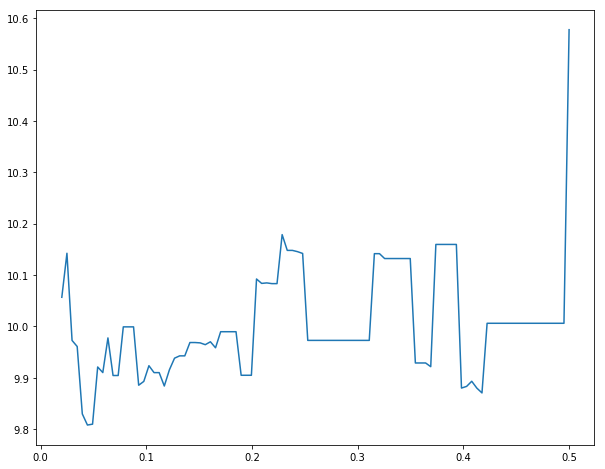

In [100]:
plt.figure(figsize=(10, 8))
plt.plot(tree_model_df['param_min_samples_leaf'], -tree_model_df['split0_test_neg_mean_squared_error'])
plt.show()

If our tree is too shallow we underfit and if our tree is too deep we overfit

# Random forests

# Gradient-boosted trees